In [1]:
from matplotlib import pyplot as plt
import math, os, re, time, random, string
import numpy as np, pandas as pd, seaborn as sns
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from collections import defaultdict
import wordcloud

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import *

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from tensorflow.keras.layers import *
from tensorflow.keras import Input, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tau\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Read data

In [2]:
df = pd.read_csv('./raw_data/train_processed.csv', encoding='latin-1')
test = pd.read_csv('./raw_data/test_processed.csv', encoding='latin-1')
df = df.dropna()
test = test.dropna()

#### Split and organize

In [3]:
train, val = train_test_split(df, test_size=0.7)

y_train = train['REMOVED']
y_val = val['REMOVED']
y_test = test['REMOVED']
train.shape
val.shape
test.shape

(6392, 12)

(14915, 12)

(7107, 12)

#### Metafeature scaling

In [4]:
scaler = StandardScaler()
scaler.fit(train.iloc[:, 2:8])

train_meta = scaler.transform(train.iloc[:, 2:8])
val_meta = scaler.transform(val.iloc[:, 2:8])
test_meta = scaler.transform(test.iloc[:, 2:8])

train_meta.shape
val_meta.shape
test_meta.shape

StandardScaler()

(6392, 6)

(14915, 6)

(7107, 6)

#### Tokenizing

In [5]:
input_dim = 200

In [6]:
train_text = [i for i in train['stemmed_no_stop']]
test_text = [i for i in test['stemmed_no_stop']]
val_text = [i for i in val['stemmed_no_stop']]

tokenizer = Tokenizer()

tokenizer.fit_on_texts(train_text)

print(len(tokenizer.word_index), 'unique tokens')

train_seq = tokenizer.texts_to_sequences(train_text)
test_seq = tokenizer.texts_to_sequences(test_text)
val_seq = tokenizer.texts_to_sequences(val_text)

train_data = pad_sequences(train_seq, input_dim)
val_data = pad_sequences(val_seq, input_dim)
test_data = pad_sequences(test_seq, input_dim)

17822 unique tokens


#### Embedding

In [7]:
embeddings_index = {}
with open('./glove/glove.6B/glove.6B.200d.txt','r', encoding="utf8") as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

400001it [00:29, 13676.37it/s]


In [8]:
word_index = tokenizer.word_index

#initialize embedding matrix with zeros
embedding_matrix = np.zeros((len(word_index) + 1, input_dim))

#add glove word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print("embedded matrix dimension", embedding_matrix.shape)

embedding = Embedding(len(word_index) + 1, input_dim, weights = [embedding_matrix],
                     input_length = 200, trainable = False)  

100%|██████████| 17822/17822 [00:00<00:00, 508737.84it/s]

embedded matrix dimension (17823, 200)


#### Modeling functions

In [12]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.5, 
                              verbose = 1, 
                              patience = 4,                        
                              min_lr = 0.0001)   
    
def model_process(model, n_epochs=20):
    model.summary()
    history = model.fit(x=[train_data, train_meta],
                        y=y_train,
                        epochs = n_epochs,
                        verbose=1,
                        callbacks=[reduce_lr],
                        validation_data = ([val_data, val_meta], y_val)
                       )
    
    scores = pd.DataFrame(history.history)
    scores[['loss', 'val_loss']].plot()
    scores[['accuracy', 'val_accuracy']].plot()
    
    y_pred = (model.predict([test_data, test_meta]) > 0.5).astype(int)
    print('\nf1 score is:', f1_score(y_test, y_pred, average = 'macro'))
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

# LSTM

In [13]:
def lstm_rnn():
    nlp_input = Input(shape = (input_dim,), name = 'nlp_input')
    meta_input_train = Input(shape = (6, ), name = 'meta_train')
    
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(0.2)(emb)

    nlp_out = LSTM(100, dropout=0.2, return_sequences=True)(emb)  
    nlp_out = SpatialDropout1D(0.2)(nlp_out)
    nlp_out = LSTM(50, dropout=0.2)(nlp_out)
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add second hidden layer
    x = Dropout(0.2)(x)
    x = (Dense(32, 
               activation = 'relu'
              ))(x)
    
    #add output layer
    x = Dropout(0.2)(x)
    preds = Dense(1, 
                  activation='sigmoid'
                 )(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(0.004), metrics = ['accuracy'])
    
    return model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 nlp_input (InputLayer)         [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 200)     3564600     ['nlp_input[0][0]']              
                                                                                                  
 spatial_dropout1d_2 (SpatialDr  (None, 200, 200)    0           ['embedding[1][0]']              
 opout1D)                                                                                         
                                                                                                  
 lstm_2 (LSTM)                  (None, 200, 100)     120400      ['spatial_dropout1d_2[0][0]

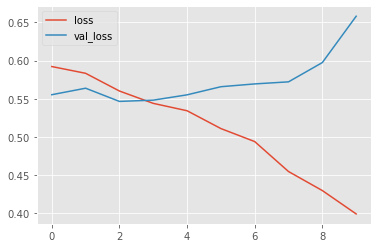

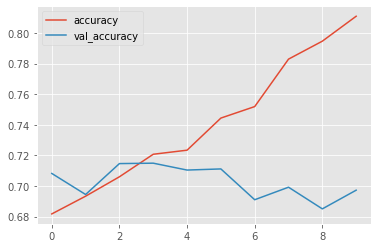

In [14]:
m2 = lstm_rnn()
model_process(m2, 10)